# Analysis Notebook - Hierarchical Bayesian Modelling

## **NOTE**:

We assume that you have cloned the analysis repository and have `cd` into the parent directory. Before starting with the analysis make sure you have first completed the dependencies set up by following the instructions described in the **`dependencies/README.md`** document. All paths defined in this Notebook are relative to the parent directory (repository). Please close this Notebook and start again by following the above guidelines if you have not completed the aforementioned steps.

## Prerequisite input files

Before starting the execution of the following code, make sure you have available in the folders `sbas/data` and `sbas/assets` the files listed below as prerequisites.

###  **`sbas/data`**.
The present analysis requires the following files to be present in the folder **`sbas/data`**.


- [x] The contents of `data.tar.gz` after unpacking them into the `sbas/data` folder with `tar xvzf data.tar.gz -C sbas/data `
- [x] `SraRunTable.txt` formerly named`SraRunTable.noCram.noExome.noWGS.totalRNA.txt` (changed in [9fd0618](https://github.com/TheJacksonLaboratory/sbas/commit/9fd06183d1df0d6c6f072861ad7ff3b84ac5cb47))
- [x] `rmats_final.se.jc.ijc.txt`
- [x] `rmats_final.se.jc.sjc.txt`
- [x] `SraRunTable.noCram.noExome.noWGS.totalRNA.txt`


Additionally, the file `GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct` which is retrieved in the script from [`https://storage.googleapis.com/gtex_analysis_v7/rna_seq_data/`](https://storage.googleapis.com/gtex_analysis_v7/rna_seq_data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct.gz) and stored into the folder 
`sbas/data` as well.


### **`sbas/assets`**
The present analysis requires the following files to be present in the folder **`sbas/assets`**.

- [x] `tissues.tsv`: metadata file with information on which tissues will be used for analysis
- [x] `splice-relevant-genes.txt`: list of RNA binding proteins that are annotated to splicing relevant functions from GO.

## Loading dependencies

If `conda` is available on your environment you can install the required dependencies by running the following commands:


```bash
time conda install -y r-base==3.6.2 &&
conda install -y r-ggplot2 r-ggsci r-coda r-rstan r-rjags r-compute.es r-snakecase &&
Rscript -e 'install.packages("runjags", repos = "https://cloud.r-project.org/")'
```



In [1]:
# Start the clock!
start_time <- Sys.time()

In [2]:
# dataviz dependencies
library(ggplot2)
library(ggsci)
library(grid)
library(gridExtra)
library(stringr)
library(snakecase)

# BDA2E-utilities dependencies
library(rstan)
library(parallel)
library(rjags)
library(runjags)
library(compute.es)

Warning message:
“package ‘ggplot2’ was built under R version 3.6.3”
Warning message:
“package ‘ggsci’ was built under R version 3.6.3”
Warning message:
“package ‘gridExtra’ was built under R version 3.6.3”
Warning message:
“package ‘snakecase’ was built under R version 3.6.3”
Warning message:
“package ‘rstan’ was built under R version 3.6.3”
Loading required package: StanHeaders

Warning message:
“package ‘StanHeaders’ was built under R version 3.6.3”
rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Warning message:
“package ‘rjags’ was built under R version 3.6.3”
Loading required package: coda

Warning message:
“package ‘coda’ was built under R version 3.6.3”

Attaching package: ‘coda’


The following object is masked from ‘package:rstan’:

    traceplot


Linke

In [3]:
file.exists("../data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct")

[1] TRUE

Download GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct from Google Cloud


In [4]:
if (!("GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct" %in% list.files("../data/"))) {
    message("Downloading GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct \nfrom https://console.cloud.google.com/storage/browser/_details/gtex_analysis_v7/rna_seq_data/ ..")
    system("wget -O ../data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz https://storage.googleapis.com/gtex_analysis_v7/rna_seq_data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct.gz", intern = TRUE)
    message("Done!\n\n")
    message("Unzipping compressed file GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz..")
    system("gunzip ../data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz", intern = TRUE)
    message("Done! \n\nThe file GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct can be found in ../data/")
}

Previously used list of tissues to use for the Hierarchical Bayesian modelling:



```R
tissue.list<-c("Heart - Left Ventricle",
               "Breast - Mammary Tissue",
               "Brain - Cortex.Brain - Frontal Cortex (BA9).Brain - Anterior cingulate cortex (BA24)",
               "Adrenal Gland",
               "Adipose - Subcutaneous",
               "Muscle - Skeletal",
               "Thyroid",
               "Cells - Transformed fibroblasts",
               "Artery - Aorta",
               "Skin - Sun Exposed (Lower leg).Skin - Not Sun Exposed (Suprapubic)")
```

In [5]:
tissues_df <- readr::read_delim("../assets/tissues.tsv", delim = "\t")

Parsed with column specification:
cols(
  name = col_character(),
  female = col_double(),
  male = col_double(),
  include = col_double(),
  display.name = col_character()
)



In [6]:
tissue.list <- tissues_df$name[ tissues_df$include ==1]

In [7]:
message(length(tissue.list), " tissues")
cat(tissue.list, sep = "\n")

39 tissues



adipose_subcutaneous
adipose_visceral_omentum
adrenal_gland
artery_aorta
artery_coronary
artery_tibial
brain_caudate_basal_ganglia
brain_cerebellar_hemisphere
brain_cerebellum
brain_cortex
brain_frontal_cortex_ba_9
brain_hippocampus
brain_hypothalamus
brain_nucleus_accumbens_basal_ganglia
brain_putamen_basal_ganglia
brain_spinal_cord_cervical_c_1
breast_mammary_tissue
cells_cultured_fibroblasts
cells_ebv_transformed_lymphocytes
colon_sigmoid
colon_transverse
esophagus_gastroesophageal_junction
esophagus_mucosa
esophagus_muscularis
heart_atrial_appendage
heart_left_ventricle
liver
lung
muscle_skeletal
nerve_tibial
pancreas
pituitary
skin_not_sun_exposed_suprapubic
skin_sun_exposed_lower_leg
small_intestine_terminal_ileum
spleen
stomach
thyroid
whole_blood


In [8]:
tissue <- tissue.list[17]  #can be replaced with a loop or argument to choose a different tissue

In [9]:
tissue

[1] "breast_mammary_tissue"

## Pattern for choosing `topTable()` files from `limma`

```bash
# {as_site_type} + '_' + {tissue} + '_' + suffix_pattern 
se_skin_not_sun_exposed_suprapubic_AS_model_B_sex_as_events.csv
```

In [10]:
dataDir <- "../data/"
assetsDir <- "../assets/"
as_site_type <- "se"
suffix_pattern <- "AS_model_B_sex_as_events.csv"

file.with.de.results <- paste0(dataDir, as_site_type, "_", tissue, "_" , suffix_pattern  )
file.with.de.results
file.exists(file.with.de.results)
system( paste0("ls -l ", file.with.de.results), intern = TRUE )

[1] "../data/se_breast_mammary_tissue_AS_model_B_sex_as_events.csv"

[1] TRUE

[1] "-rw-r--r-- 1 jovyan users 4688985 Jun 18 16:59 ../data/se_breast_mammary_tissue_AS_model_B_sex_as_events.csv"

In [11]:
events.table         <- read.table(file.with.de.results, sep = ",")
head(events.table, 2)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
XIST-10154,-6.796072,1.385720,-38.73465,5.301573e-131,1.523859e-126,280.9110
XIST-10149,-7.124726,1.597306,-38.68238,7.868530e-131,1.523859e-126,280.5225


## Add annotation columns to the topTable dataframe:

The feature information is encoded in the topTable dataframe as rownames. The `ID` and `geneSymbol` variables have been combined in the following pattern:

```console
{geneSymbol}-{ID} 
```

- `ID`: everything **_after_** last occurence of hyphen `-`
example: 
```R
stringr::str_replace("apples - oranges - bananas", "^.+-", "")
```

```console
# output:

' bananas'
```

- `geneSymbol`: everything **_before_** last occurence of `-`
example: 

```R
sub('-[^-]*$', '',"apples - oranges - bananas")
```

```console
# output:

'apples - oranges '
```

```diff
- NOTE: The above solution covers the cases where a hyphen is part of the geneSymbol.
```

In [12]:
cols_initially <- colnames(events.table)
cols_initially

[1] "logFC"     "AveExpr"   "t"         "P.Value"   "adj.P.Val" "B"

In [13]:
events.table[["ID"]] <- stringr::str_replace(rownames(events.table),  "^.+-", "")
events.table[["gene_name"]] <- sub('-[^-]*$', '', rownames(events.table))

In [14]:
keepInOrderCols <- c("gene_name", "ID", cols_initially)

In [15]:
events.table <- events.table[ , keepInOrderCols ]

In [16]:
tail(events.table, 2)

,gene_name,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RPLP0-28659,RPLP0,28659,0.02222658,9.584065,0.1354014,0.8923696,0.9544973,-7.100906
CD74-25493,CD74,25493,-0.01277937,9.839909,-0.1084203,0.9137222,0.9639965,-7.254767


## Define filepaths of required inputs

`file.with.de.results` has been defined above

In [17]:
rbp.table.name        <- paste0(assetsDir, "splice-relevant-genes.txt")
file.exists(rbp.table.name)

[1] TRUE

In [18]:
events.table.name     <- paste0(dataDir, "fromGTF.SE.txt")
file.exists(events.table.name)

[1] TRUE

In [19]:
inc.counts.file.name  <- paste0(dataDir, "rmats_final.se.jc.ijc.txt")
file.exists(inc.counts.file.name)

[1] TRUE

In [20]:
skip.counts.file.name <- paste0(dataDir, "rmats_final.se.jc.sjc.txt")
file.exists(skip.counts.file.name)

[1] TRUE

In [21]:
metadata.file.name    <- paste0(dataDir, "SraRunTable.txt")
file.exists(metadata.file.name)

[1] TRUE

In [22]:
expression.file.name  <- paste0(dataDir, "GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct")
file.exists(expression.file.name)

[1] TRUE

## Use the define filepaths to load/read in the tables 

Load the skip and inclusion count matrices, and the list of RNA binding proteins that are annotated to either:
- mRNA splicing, via spliceosome `(GO:0000398)`,
- regulation of mRNA splicing, via spliceosome `(GO:0048024)`, or 
- both. 

The table has the:
- Gene Symbol
- the Uniprot ID (`uprot.id`)
- the NCBI Gene ID (`gene.id`) and 
- boolean columns for being 
  - `S`=mRNA splicing, via spliceosome `(GO:0000398)` and 
  - `R`=regulation of mRNA splicing, via spliceosome `(GO:0048024)`.

### Filtering of the `topTable()` object

- `abs(events.table$logFC)>=log2(1.5)`
- `events.table$adj.P.Val<=0.05`

In [23]:
dim(events.table)
events.table <- events.table[abs(events.table$logFC)>=log2(1.5) & events.table$adj.P.Val<=0.05,]
dim(events.table)
head(events.table,2)

[1] 38733     8

[1] 3163    8

,gene_name,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
XIST-10154,XIST,10154,-6.796072,1.385720,-38.73465,5.301573e-131,1.523859e-126,280.9110
XIST-10149,XIST,10149,-7.124726,1.597306,-38.68238,7.868530e-131,1.523859e-126,280.5225


Make sure this command has been executed before `gunzip sbas/data/fromGTF.*` as the files are expected uncompressed.


In [24]:
annot.table  <- read.table(events.table.name,header=T)
dim(annot.table)
head(annot.table, 1)

[1] 42611    11

,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,ENSG00000034152.18,MAP2K3,chr17,+,21287990,21288091,21284709,21284969,21295674,21295769


In [25]:
merged.table <- merge(events.table, annot.table, by="ID")

In [26]:
dim(merged.table)
head(merged.table, 2)

[1] 3163   18

,ID,gene_name,logFC,AveExpr,t,P.Value,adj.P.Val,B,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
1,10012,RBM4B,0.8450169,1.183428,6.352709,6.335981e-10,4.076604e-08,12.144677,ENSG00000173914.12,RBM4B,chr11,-,66670935,66670983,66668970,66669291,66676667,66677091
2,10013,RBM4B,-0.7621263,1.752806,-4.689350,3.885523e-06,9.641124e-05,3.795546,ENSG00000173914.12,RBM4B,chr11,-,66668614,66669291,66664997,66665578,66676667,66677091


In [27]:
rbp.table    <- read.table(rbp.table.name,sep="\t",header=TRUE)
dim(rbp.table)
head(rbp.table, 1)

[1] 351   6

,Gene,uprot.id,gene.id,S,R,omim
,<fct>,<fct>,<int>,<lgl>,<lgl>,<fct>
1,AAR2,Q9Y312,25980,TRUE,FALSE,n/a


Make sure this command has been executed before `gunzip sbas/data/rmats_final.se.jc.*jc.*` as the files are expected uncompressed.


In [28]:
inc.counts   <- as.data.frame(data.table::fread(inc.counts.file.name))
dim(inc.counts)
inc.counts[1:2,1:3]

[1] 42611  8674

,ID,SRR1068788,SRR1068808
,<int>,<int>,<int>
1,1,0,0
2,2,26,247


In [29]:
skip.counts  <- as.data.frame(data.table::fread(skip.counts.file.name))
dim(skip.counts)
skip.counts[1:2,1:3]

[1] 42611  8674

,ID,SRR1068788,SRR1068808
,<int>,<int>,<int>
1,1,2,0
2,2,0,0


## Check `dim()` of loaded objects

In [30]:
dim(events.table)
dim(annot.table)
dim(merged.table)
dim(rbp.table)
dim(inc.counts)
dim(skip.counts)

[1] 3163    8

[1] 42611    11

[1] 3163   18

[1] 351   6

[1] 42611  8674

[1] 42611  8674

## Read sample info

Make sure you have unzipped the file first by typing:

```bash
 gunzip sbas/data/SraRunTable.txt.gz 
```

as the file is expected to be uncompressed

In [31]:
metadata.file.name
file.exists(metadata.file.name)
system(paste0("ls -l", " ../data/Sra*"), intern = TRUE)

[1] "../data/SraRunTable.txt"

[1] TRUE

[1] "-rw-r--r-- 1 jovyan users 16768568 Jun 17 11:58 ../data/SraRunTable.txt"

In [32]:
meta.data    <- read.csv(metadata.file.name,header=TRUE)
dim(meta.data)
head(meta.data, 1)

[1] 24667    79

,Run,analyte_type,Assay.Type,AvgSpotLen,Bases,BioProject,BioSample,biospecimen_repository,biospecimen_repository_sample_id,body_site,⋯,data_type..run.,product_part_number..exp.,product_part_number..run.,sample_barcode..exp.,sample_barcode..run.,is_technical_control,target_set..exp.,primary_disease..exp.,secondary_accessions..run.,Alignment_Provider..run.
,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
1,SRR3136805,DNA,WGS,302,116341565242,PRJNA244100,SAMN02649364,Cloud Testing,NA12878,Peripheral blood,⋯,,,,NA,NA,,,,,IRC Harmonized


In [33]:
meta.data$body_site[1:3]

[1] Peripheral blood Peripheral blood Peripheral blood
56 Levels: Adipose - Subcutaneous ... Whole Blood

In [34]:
meta.data[["body_site"]] <- as.character(meta.data[["body_site"]])

In [35]:
meta.data$body_site[1:3]

[1] "Peripheral blood" "Peripheral blood" "Peripheral blood"

In [36]:
meta.data <- meta.data[ snakecase::to_snake_case(meta.data$body_site) == tissue,]

In [37]:
tissue
dim(meta.data)
head(meta.data,1)

[1] "breast_mammary_tissue"

[1] 526  79

,Run,analyte_type,Assay.Type,AvgSpotLen,Bases,BioProject,BioSample,biospecimen_repository,biospecimen_repository_sample_id,body_site,⋯,data_type..run.,product_part_number..exp.,product_part_number..run.,sample_barcode..exp.,sample_barcode..run.,is_technical_control,target_set..exp.,primary_disease..exp.,secondary_accessions..run.,Alignment_Provider..run.
,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<chr>,⋯,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
233,SRR821498,RNA:Total RNA,RNA-Seq,152,7879119272,PRJNA75899,SAMN01994192,GTEx,GTEX-WI4N-1426-SM-3LK7H,Breast - Mammary Tissue,⋯,,,,NA,NA,,,,,


In [38]:
# Undo snakecasse of body_site
tissue
tissue <- unique(meta.data$body_site)
tissue

[1] "breast_mammary_tissue"

[1] "Breast - Mammary Tissue"

In [39]:
dim(inc.counts)
inc.counts   <- inc.counts[,colnames(inc.counts) %in% meta.data$Run]
dim(inc.counts)

[1] 42611  8674

[1] 42611   191

In [40]:
dim(skip.counts)
skip.counts  <- skip.counts[,colnames(skip.counts) %in% meta.data$Run]
dim(skip.counts)

[1] 42611  8674

[1] 42611   191

In [41]:
sd.threshold <- quantile(apply(inc.counts,1,sd)+apply(skip.counts,1,sd),0.95)
sd.threshold

95% 
116.8873

In [42]:
dim(skip.counts)
skip.counts  <- skip.counts[rownames(skip.counts) %in% merged.table$ID,]
dim(skip.counts)

[1] 42611   191

[1] 3163  191

In [43]:
dim(inc.counts)
inc.counts   <- inc.counts[rownames(inc.counts) %in% merged.table$ID,]
dim(inc.counts)

[1] 42611   191

[1] 3163  191

In [44]:
nrow(skip.counts)>100

[1] TRUE

In [45]:
if (nrow(skip.counts)>100)
{
  select.events <- apply(inc.counts,1,sd)+apply(skip.counts,1,sd)>sd.threshold
  inc.counts    <- inc.counts[select.events,]
  skip.counts   <- skip.counts[select.events,]
  merged.table  <- merged.table[select.events,]
}

In [46]:
dim(inc.counts)
dim(skip.counts)
dim(merged.table)

[1] 142 191

[1] 142 191

[1] 142  18

## Read expression data:

In [47]:
expression.file.name
file.exists(expression.file.name)

[1] "../data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct"

[1] TRUE

In [48]:
expression.mat <- read.table(expression.file.name, 
                             nrows = 1,
                             sep = "\t",
                             header = T,
                             skip = 2)

In [49]:
dim(expression.mat)
head(expression.mat, 2)

[1]     1 11690

,Name,Description,GTEX.1117F.0226.SM.5GZZ7,GTEX.111CU.1826.SM.5GZYN,GTEX.111FC.0226.SM.5N9B8,GTEX.111VG.2326.SM.5N9BK,GTEX.111YS.2426.SM.5GZZQ,GTEX.1122O.2026.SM.5NQ91,GTEX.1128S.2126.SM.5H12U,GTEX.113IC.0226.SM.5HL5C,⋯,GTEX.ZVE2.0006.SM.51MRW,GTEX.ZVP2.0005.SM.51MRK,GTEX.ZVT2.0005.SM.57WBW,GTEX.ZVT3.0006.SM.51MT9,GTEX.ZVT4.0006.SM.57WB8,GTEX.ZVTK.0006.SM.57WBK,GTEX.ZVZP.0006.SM.51MSW,GTEX.ZVZQ.0006.SM.51MR8,GTEX.ZXES.0005.SM.57WCB,GTEX.ZXG5.0005.SM.57WCN
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000223972.4,DDX11L1,0.1082,0.1158,0.02104,0.02329,0,0.04641,0.03076,0.09358,⋯,0.09012,0.1462,0.1045,0,0.6603,0.695,0.1213,0.4169,0.2355,0.145


In [50]:
colnames(expression.mat)[1:3]

[1] "Name"                     "Description"             
[3] "GTEX.1117F.0226.SM.5GZZ7"

In [51]:
colnames.expression.mat <- colnames(expression.mat)

In [52]:
length(colnames.expression.mat)
colnames.expression.mat[1:4]

[1] 11690

[1] "Name"                     "Description"             
[3] "GTEX.1117F.0226.SM.5GZZ7" "GTEX.111CU.1826.SM.5GZYN"

In [53]:
length(colnames.expression.mat)

[1] 11690

In [54]:
total.samples           <- length(colnames.expression.mat)
total.samples

[1] 11690

In [55]:
meta.data$Sample.Name[1]
gsub("-","\\.",meta.data$Sample.Name[1])

[1] GTEX-WI4N-1426-SM-3LK7H
14224 Levels: GTEX-1117F-0003-SM-58Q7G ... NA19475

[1] "GTEX.WI4N.1426.SM.3LK7H"

In [56]:
meta.data$Sample.Name   <- gsub("-","\\.",meta.data$Sample.Name)

In [57]:
dim(meta.data)
meta.data               <- meta.data[meta.data$Sample.Name %in% colnames(expression.mat),]
dim(meta.data)

[1] 526  79

[1] 500  79

In [58]:
head(expression.mat)

,Name,Description,GTEX.1117F.0226.SM.5GZZ7,GTEX.111CU.1826.SM.5GZYN,GTEX.111FC.0226.SM.5N9B8,GTEX.111VG.2326.SM.5N9BK,GTEX.111YS.2426.SM.5GZZQ,GTEX.1122O.2026.SM.5NQ91,GTEX.1128S.2126.SM.5H12U,GTEX.113IC.0226.SM.5HL5C,⋯,GTEX.ZVE2.0006.SM.51MRW,GTEX.ZVP2.0005.SM.51MRK,GTEX.ZVT2.0005.SM.57WBW,GTEX.ZVT3.0006.SM.51MT9,GTEX.ZVT4.0006.SM.57WB8,GTEX.ZVTK.0006.SM.57WBK,GTEX.ZVZP.0006.SM.51MSW,GTEX.ZVZQ.0006.SM.51MR8,GTEX.ZXES.0005.SM.57WCB,GTEX.ZXG5.0005.SM.57WCN
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000223972.4,DDX11L1,0.1082,0.1158,0.02104,0.02329,0,0.04641,0.03076,0.09358,⋯,0.09012,0.1462,0.1045,0,0.6603,0.695,0.1213,0.4169,0.2355,0.145


In [59]:
meta.data <- meta.data[!duplicated(meta.data$Sample.Name),]

In [60]:
dim(meta.data)

[1] 290  79

In [61]:
inc.counts <- inc.counts[,colnames(inc.counts) %in% meta.data$Run]
dim(inc.counts)
head(inc.counts,1)

[1] 142   7

,SRR808428,SRR808942,SRR811285,SRR812198,SRR815208,SRR820571,SRR821498
,<int>,<int>,<int>,<int>,<int>,<int>,<int>
676,14,11,29,26,22,21,13


In [62]:
skip.counts <- skip.counts[,colnames(skip.counts) %in% meta.data$Run]
dim(skip.counts)
head(skip.counts, 1)

[1] 142   7

,SRR808428,SRR808942,SRR811285,SRR812198,SRR815208,SRR820571,SRR821498
,<int>,<int>,<int>,<int>,<int>,<int>,<int>
676,89,119,270,364,108,198,185


In [63]:
meta.data <- meta.data[meta.data$Run %in% colnames(inc.counts),]
dim(meta.data)
head(meta.data, 1)

[1]  7 79

,Run,analyte_type,Assay.Type,AvgSpotLen,Bases,BioProject,BioSample,biospecimen_repository,biospecimen_repository_sample_id,body_site,⋯,data_type..run.,product_part_number..exp.,product_part_number..run.,sample_barcode..exp.,sample_barcode..run.,is_technical_control,target_set..exp.,primary_disease..exp.,secondary_accessions..run.,Alignment_Provider..run.
,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<chr>,⋯,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
233,SRR821498,RNA:Total RNA,RNA-Seq,152,7879119272,PRJNA75899,SAMN01994192,GTEx,GTEX-WI4N-1426-SM-3LK7H,Breast - Mammary Tissue,⋯,,,,NA,NA,,,,,


In [64]:
colnames.expression.mat[1:4]

[1] "Name"                     "Description"             
[3] "GTEX.1117F.0226.SM.5GZZ7" "GTEX.111CU.1826.SM.5GZYN"

In [65]:
dim(expression.mat)
head(expression.mat, 1)

[1]     1 11690

,Name,Description,GTEX.1117F.0226.SM.5GZZ7,GTEX.111CU.1826.SM.5GZYN,GTEX.111FC.0226.SM.5N9B8,GTEX.111VG.2326.SM.5N9BK,GTEX.111YS.2426.SM.5GZZQ,GTEX.1122O.2026.SM.5NQ91,GTEX.1128S.2126.SM.5H12U,GTEX.113IC.0226.SM.5HL5C,⋯,GTEX.ZVE2.0006.SM.51MRW,GTEX.ZVP2.0005.SM.51MRK,GTEX.ZVT2.0005.SM.57WBW,GTEX.ZVT3.0006.SM.51MT9,GTEX.ZVT4.0006.SM.57WB8,GTEX.ZVTK.0006.SM.57WBK,GTEX.ZVZP.0006.SM.51MSW,GTEX.ZVZQ.0006.SM.51MR8,GTEX.ZXES.0005.SM.57WCB,GTEX.ZXG5.0005.SM.57WCN
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000223972.4,DDX11L1,0.1082,0.1158,0.02104,0.02329,0,0.04641,0.03076,0.09358,⋯,0.09012,0.1462,0.1045,0,0.6603,0.695,0.1213,0.4169,0.2355,0.145


tissue <- unique(meta.data$body_site [ meta.data$body_site == tissue])
tissue

In [66]:
col.in.tissue<-c()
for (col in colnames.expression.mat)
  
  col.in.tissue<-c(col.in.tissue, (col %in% meta.data$Sample.Name) && (meta.data$body_site[which(meta.data$Sample.Name==col)] %in% tissue) && (meta.data$submitted_subject_id[which(meta.data$Sample.Name==col)]!='GTEX-11ILO'))

In [67]:
length(col.in.tissue)
table(col.in.tissue)

[1] 11690

col.in.tissue
FALSE  TRUE 
11683     7 

In [68]:
length(colnames.expression.mat)
length(col.in.tissue)

col.in.tissue[1:3]

[1] 11690

[1] 11690

[1] FALSE FALSE FALSE

In [69]:
# colClasses is used to skip columns
expression.mat <-read.table(expression.file.name, 
                            sep= "\t",
                            header = T,
                            skip = 2, 
                            colClasses = ifelse(col.in.tissue, "numeric", "NULL"))

In [70]:
length(col.in.tissue)

[1] 11690

## Read gene names:

In [71]:
dim(expression.mat)
expression.mat <- expression.mat[,order(match(colnames(expression.mat),meta.data$Sample.Name))]
dim(expression.mat)

[1] 56202     7

[1] 56202     7

In [72]:
inc.counts     <- inc.counts[,order(match(colnames(inc.counts),meta.data$Run))]

In [73]:
skip.counts    <- skip.counts[,order(match(colnames(skip.counts),meta.data$Run))]

In [74]:
all.genes      <- read.table(expression.file.name,sep="\t",header=T,skip=2,colClasses = c(rep("character", 2), rep("NULL", total.samples-2)))

In [75]:
expression.mat <- expression.mat[!duplicated(all.genes$Description),]

In [76]:
all.genes      <- all.genes[!duplicated(all.genes$Description),]

In [77]:
skip.counts    <- skip.counts[merged.table$geneSymbol %in% all.genes$Description,]

In [78]:
inc.counts     <- inc.counts[merged.table$geneSymbol %in% all.genes$Description,]

In [79]:
merged.table   <- merged.table[merged.table$geneSymbol %in% all.genes$Description,]

In [80]:
gene.names     <- unique(merged.table$geneSymbol)

In [81]:
expression.mat <- expression.mat[all.genes$Description %in% c(as.character(rbp.table$Gene),as.character(gene.names)),]

In [82]:
rownames.expression.mat <-all.genes$Description[all.genes$Description %in% c(as.character(rbp.table$Gene),as.character(gene.names))]

In [83]:
expression.mat <-expression.mat[!duplicated(rownames.expression.mat),]

In [84]:
rownames.expression.mat <-rownames.expression.mat[!duplicated(rownames.expression.mat)]

## Prepare expression of genes and RBPS:

In [85]:
num.events     <- nrow(merged.table)
num.events

[1] 126

In [86]:
event.to.gene  <- c()

In [87]:
gexp           <- expression.mat[rownames.expression.mat %in% gene.names,]
dim(gexp)

[1] 107   7

In [88]:
rownames(gexp) <- rownames.expression.mat[rownames.expression.mat %in% gene.names]

In [89]:
gexp           <- gexp[order(match(rownames(gexp),gene.names)),]

In [90]:
gexp           <- log2(gexp+0.5)

In [91]:
gexp           <- gexp-rowMeans(gexp)

In [92]:
gexp[apply(gexp,1,sd)>0,] <- gexp[apply(gexp,1,sd)>0,]/apply(gexp[apply(gexp,1,sd)>0,],1,sd)

In [93]:
rexp           <- expression.mat[rownames.expression.mat %in% rbp.table$Gene,]

In [94]:
rownames(rexp) <- rownames.expression.mat[rownames.expression.mat %in% rbp.table$Gene]

In [95]:
rexp           <- rexp[order(match(rownames(rexp),rbp.table$Gene)),]

In [96]:
rexp           <- log2(rexp+0.5)

In [97]:
rexp           <- rexp-rowMeans(rexp)

In [98]:
rexp           <- rexp/apply(rexp,1,function(v){ifelse(sum(v==v[1])<length(v),sd(v),1)})

In [99]:
for (i in (1:num.events))
  event.to.gene<-c(event.to.gene,which(unique(merged.table$geneSymbol)==merged.table[i,"geneSymbol"]))
sex<-ifelse(meta.data$sex=="male",1,0)

In [100]:
sex[1:4]

[1] 0 0 0 1

In [101]:
end_time <- Sys.time()
end_time - start_time

Time difference of 2.852988 mins

## Run stan:

In [102]:
dataList = list(
  as = round(skip.counts) ,   #skip event counts across experiments
  c = round(skip.counts+inc.counts)    , #total counts for event, i.e. skip+inclusion, across experiments
  gexp = gexp, #read counts for genes (from gtex, take the raw counts) across experiments
  rexp = rexp, #read counts for RBPs (from gtex, take the raw counts)
  event_to_gene = event.to.gene,  #the gene index for each event (1 to the number of distinct genes) 
  Nrbp = nrow(rexp), #number of RBPs
  Nevents = nrow(merged.table),  #most varying AS events in 
  Nexp = ncol(expression.mat),#number of experiments such that we measured each event, gene and RBP in each experiment
  Ngenes = nrow(gexp),
  sex=sex
)


modelString = "
data {
int<lower=0> Nevents;
int<lower=0> Nexp;
int<lower=0> Nrbp;
int<lower=0> Ngenes;
int<lower=0> as[Nevents,Nexp] ;
int<lower=0> c[Nevents,Nexp] ;
matrix[Ngenes,Nexp] gexp ; 
matrix[Nrbp,Nexp] rexp ; 
int<lower=0> event_to_gene[Nevents];
int<lower=0,upper=1> sex[Nexp];

}


parameters {
real beta0[Nevents] ;
real beta1[Nevents] ;
matrix[Nevents,Nrbp] beta2 ;
real beta3[Nevents];
real beta4[Nrbp];

}
model {

for ( i in 1:Nexp ) {  


    for ( j in 1:Nevents ) if (c[j,i]>0) { 

      as[j,i] ~ binomial(c[j,i], inv_logit(beta0[j]+beta1[j]*sex[i]+dot_product(beta2[j,],rexp[,i])+beta3[j]*gexp[event_to_gene[j],i] ) );

  }
}

for (k in 1:Nrbp){

  for ( j in 1:Nevents ) { 

        beta2[j,k] ~normal(beta4[k],1);
  }

  beta4[k]~normal(0,1);

}


for ( j in 1:Nevents ) { 

    beta1[j] ~ normal(0,1);
    beta0[j] ~ normal(0,1);
    beta3[j] ~ normal(0,1);
  }

}
"

# Start the clock!
start_time <- Sys.time()

stanDso <- rstan::stan_model( model_code=modelString ) 
stanFit <- sampling( object=stanDso , 
                    data = dataList , 
                    chains = 2 , #3
                    iter = 80, #8000
                    warmup = 60, #6000
                    thin = 1,
                    init = 0, 
                    cores = parallel::detectCores() - 2 )

mcmcCoda = coda::mcmc.list( lapply( 1:ncol(stanFit) , function(x) { mcmc(as.array(stanFit)[,x,]) } ) )

end_time <- Sys.time()
end_time - start_time

Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”
Warning message:
“There were 39 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 2.9, indicating chains have not mixed.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running 

Time difference of 13.72803 mins

# > Inspect from here onwards

- What files are needed from here to be saved?
- Is the diagnostic plotting helpful for keeping in this notebook?

In [109]:
source("../dimorphAS/DBDA2Eprograms/DBDA2E-utilities.R")


*********************************************************************
Kruschke, J. K. (2015). Doing Bayesian Data Analysis, Second Edition:
A Tutorial with R, JAGS, and Stan. Academic Press / Elsevier.
*********************************************************************



## Initialising dataframe with columns `coef,rbp,tissue`

In [110]:
df <-data.frame(coef=NULL,rbp=NULL,tissue=NULL)

Before running the following, use the Session menu to set working directory to source file location
```R
setwd(dir = "../dimorphAS/DBDA2Eprograms/")
```

Data from former analysis (submission 2017)
```R
load("../dimorphAS/figures/oldFigureDrafts/figure3b.RData")
```

### This invokes X11 which is not available for all systems, and won"t work in a NextFlow pipeline

```
diagMCMC(mcmcCoda , parName=c("beta2[101,87]"))
```

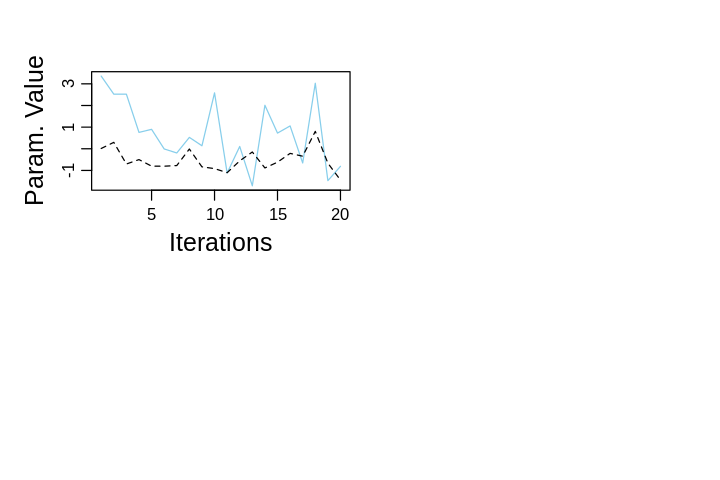

In [111]:
options(repr.plot.width=6, repr.plot.height=4)

codaObject <- mcmcCoda 
parName    <- c("beta2[101,87]") #varnames(codaObject)[1]
saveName   <- NULL
saveType   <- "jpg"


DBDAplColors = c("skyblue",
               "black",
               "royalblue",
               "steelblue")

#openGraph(height=5,width=7)
    
par(mar=0.5+c(3,4,1,0) , 
  oma=0.1+c(0,0,2,0) , 
  mgp=c(2.25,0.7,0) , 
  cex.lab=1.5 )
    
layout(matrix(1:4,nrow=2))
  # traceplot and gelman.plot are from CODA package:
require(coda)
coda::traceplot( codaObject[,c(parName)], 
              main="" , 
              ylab="Param. Value" ,
              col=DBDAplColors )

In [112]:
options(repr.plot.width=6, repr.plot.height=4)
tryVal = try(
coda::gelman.plot(codaObject[,c(parName)] , 
                  main="",
                  auto.layout=FALSE,
                  col=DBDAplColors )
)  

Error in gelman.preplot(x, bin.width = bin.width, max.bins = max.bins,  : 
  Insufficient iterations to produce Gelman-Rubin plot


[1] "Warning: coda::gelman.plot fails for beta2[101,87]"


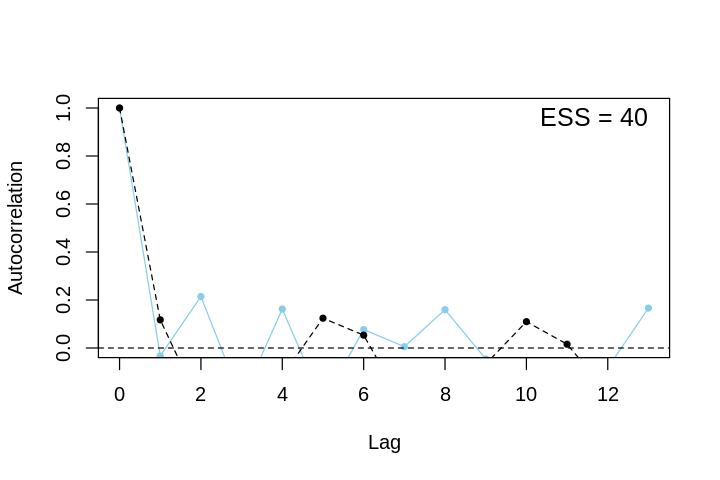

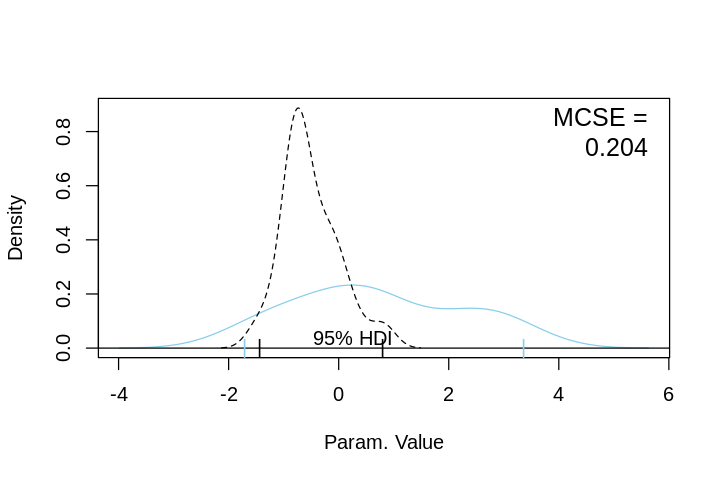

In [113]:
options(repr.plot.width=6, repr.plot.height=4)

# if it runs, gelman.plot returns a list with finite shrink values:
  if ( class(tryVal)=="try-error" ) {
    plot.new() 
    print(paste0("Warning: coda::gelman.plot fails for ",parName))
  } else { 
    if ( class(tryVal)=="list" & !is.finite(tryVal$shrink[1]) ) {
      plot.new() 
      print(paste0("Warning: coda::gelman.plot fails for ",parName))
    }
  }
  DbdaAcfPlot(codaObject,parName,plColors=DBDAplColors)
  DbdaDensPlot(codaObject,parName,plColors=DBDAplColors)
  mtext( text=parName , outer=TRUE , adj=c(0.5,0.5) , cex=2.0 )
  if ( !is.null(saveName) ) {
    saveGraph( file=paste0(saveName,"Diag",parName), type=saveType)
  }



In [114]:
##Collect coefficients for RBPs whose 95% HDI does not contain 0:

In [116]:
rbp.names<-rownames(rexp)

df<-data.frame(coef=NULL,rbp=NULL,tissue=NULL)

hdi<-HPDinterval(mcmcCoda)  

s <- summary(mcmcCoda)

m <- s$statistics[,"Mean"]

beta2.mat<-matrix(nrow=nrow(merged.table),ncol=length(rbp.names))

for (rbp in (1:length(rbp.names)))
  
  for (event in (1:nrow(merged.table)))
  {
    
    var.name<-paste0("beta2[",event,",",rbp,"]")
    
    low<-hdi[[1]][rownames(hdi[[1]])==var.name][1]
    
    high<-hdi[[1]][rownames(hdi[[1]])==var.name][2]
    
    beta2.mat[event,rbp]<-m[grepl(paste0("beta2\\[",event,",",rbp,"\\]"),names(m))]
    
    if (low<0 && high>0)
      
      beta2.mat[event,rbp]<-0
    
  }



colnames(beta2.mat)=rbp.names

for (rbp in rbp.names)
  
  df<-rbind(df,cbind(beta2.mat[,colnames(beta2.mat)==rbp],rep(rbp,nrow(beta2.mat)),rep(tissue,nrow(beta2.mat)))  )


colnames(df)<-c("Coef","RBP","Tissue")
    
df$Coef<-as.numeric(as.character(df$Coef))


## Display a violin plot for some selected RBPs:

```R
labels<-read.table('/Users/karleg/Dimorph/labels.tsv',sep='\t',header=T)
labels$X
labels$tissue
```

In [132]:
df$Tissue<-as.character(df$Tissue)
unique(df$Tissue)

[1] "Breast - Mammary Tissue"

In [133]:
dim(df)
head(df,1)

[1] 42714     3

,Coef,RBP,Tissue
,<dbl>,<chr>,<chr>
1,0,AAR2,Breast - Mammary Tissue


In [148]:
head_df <- head(df[order(df$Coef), ], 100)
selected_RBPs  <- unique(head_df$RBP)
selected_RBPs

[1] "RNPS1"  "LSM2"   "CRNKL1" "PPWD1"

In [149]:
df$Tissue<-as.character(df$Tissue)

for (i in 1:nrow(df))
  
  if (df$Tissue[i] %in% tissue)
    
    df$Tissue[i]<-as.character(labels$X[which(as.character(labels$tissue)==as.character(df$Tissue[i]))])




ERROR: Error: $ operator is invalid for atomic vectors


In [150]:
df<-df[df$Coef!=0,]

In [154]:
df$RBP<-as.character(df$RBP)

df1<-df[df$RBP %in% c("RNPS1", "LSM2","CRNKL1", "PPWD1"),]

pn1<-ggplot(df1,aes(factor(RBP),Coef)) + geom_violin(aes(fill="red")) + scale_fill_manual(values = "#4DBBD5FF") 

pn1 <- pn1 + theme_minimal() +  theme(text = element_text(size=20),
                                      axis.text = element_text(size=20, hjust=0.5),
                                      axis.title.x=element_blank(),
                                      axis.title.y = element_text(size=24),
                                      plot.title = element_text(hjust = 0.5),
                                      legend.position = "none") + ylab("") + labs(title="")+ylim(-2,2)+ geom_hline(yintercept=0)



Warning message:
“Removed 12 rows containing non-finite values (stat_ydensity).”


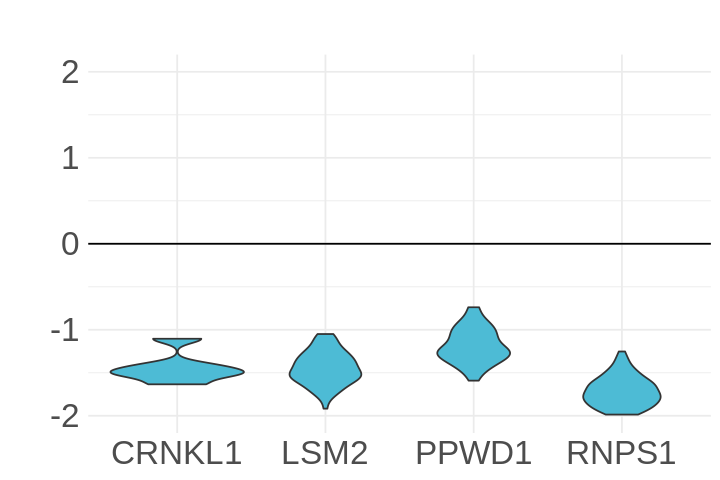

In [155]:
pn1

## Create barplot of the number of RBPs that tend to promote skipping, the number of RBPs that tend to promote
inclusion and the number of RBPs whose effect is context-specific, for the two RBP groups

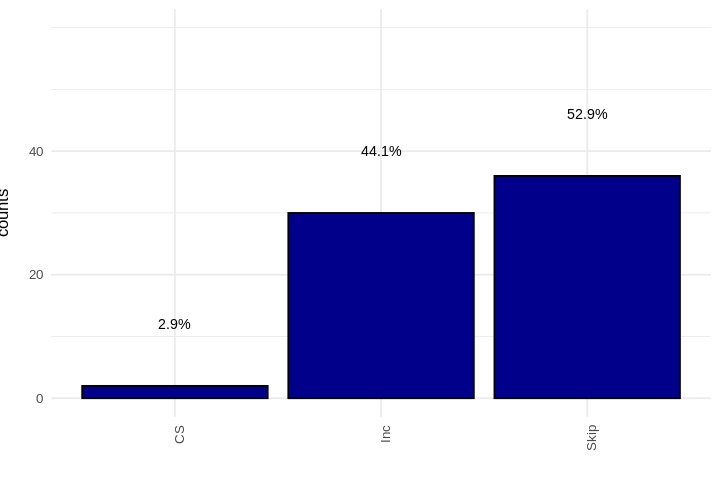

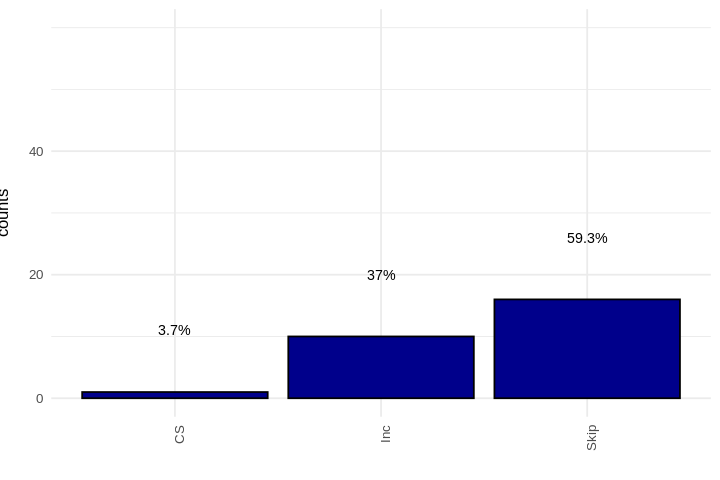

In [156]:
spliceosome_genes = as.character(rbp.table$Gene[rbp.table$S=="TRUE"])

splice_regulation_genes = as.character(rbp.table$Gene[rbp.table$R=="TRUE"])

for (RBP_set in list(spliceosome=spliceosome_genes,splice_regulation=splice_regulation_genes))
{
  sum.pos<-sort(unlist(lapply(lapply(split(df$Coef[df$RBP %in% RBP_set],df$RBP[df$RBP %in% RBP_set]),">",0),sum)),decreasing = T)
  
  sum.neg<-sort(unlist(lapply(lapply(split(df$Coef[df$RBP %in% RBP_set],df$RBP[df$RBP %in% RBP_set]),"<",0),sum)),decreasing = T)
  
  sum.pos<-sum.pos[order(names(sum.pos))]
  
  sum.neg<-sum.neg[order(names(sum.neg))]
  
  pos.rbps<-names(which(sum.pos/(sum.pos+sum.neg)>=0.75 & (sum.pos+sum.neg>quantile(sum.pos+sum.neg,0.2))))
  
  neg.rbps<-names(which(sum.pos/(sum.pos+sum.neg)<=0.25 & (sum.pos+sum.neg>quantile(sum.pos+sum.neg,0.2))))
  
  cs.rbps<-names(which(sum.pos/(sum.pos+sum.neg)>0.25 & sum.pos/(sum.pos+sum.neg)<0.75 & (sum.pos+sum.neg>quantile(sum.pos+sum.neg,0.2))))
  
  df.counts<-data.frame(type=c("Skip","Inc","CS"),counts=c(length(pos.rbps),length(neg.rbps),length(cs.rbps)))
  
  pn4_new <- ggplot(df.counts, aes(type, counts)) +  
    geom_bar(fill = "#00008B",color="black", position = "dodge", stat="identity") + 
    geom_text(aes(x = type, y = counts + 10, label = paste(100 * round(counts/sum(counts), 3), "%", sep = "")), size = 3) +
    guides(fill=FALSE) +
    xlab("") + scale_y_continuous(breaks = c(0, 20, 40), limits = c(0, 60))+
    theme_minimal() +
    theme(
      axis.text = element_text(size = 8), 
      axis.text.x = element_text(angle = 90, hjust = 1), 
      axis.title = element_text(size = 10),
      axis.title.y = element_text(vjust = 5)
    )
  show(pn4_new  )
}




In [162]:
file.exists("summary_hbm.txt")

[1] FALSE

In [161]:
if ( ("lv.txt" %in% list.files("../data/")) && ("mt.txt" %in% list.files("../data/"))) {
        message("The files lv.txt or mt.txt are available in the folder ../data/! \n")
        message("The perl parseMT.pl command will not be re-run \n")
}


if ( (!("lv.txt" %in% list.files("../data/"))) | (!("mt.txt" %in% list.files("../data/")))) {
        message("The files lv.txt or mt.txt not found in the folder ../data/ \n")
        message("Generating lv.txt and mt.txt with perl parseMT.pl using summary_hbm.txt as input .. \n")
        system(paste0("perl parseMT.pl > parseMT_output.txt && ", 
                      "mv lv.txt ../data/ && ",
                      "mv mt.txt ../data/ && ",
                      "cp summary_hbm.txt  ../data/"), 
               intern  = TRUE)
        message("Done!\n")
}



The files lv.txt or mt.txt not found in the folder ../data/ 


Generating lv.txt and mt.txt with perl parseMT.pl using summary_hbm.txt as input .. 


Warning message in system(paste0("perl parseMT.pl > parseMT_output.txt && ", "mv lv.txt ../data/ && ", :
“running command 'perl parseMT.pl > parseMT_output.txt && mv lv.txt ../data/ && mv mt.txt ../data/ && cp summary_hbm.txt  ../data/' had status 2”
Done!




## Metadata

For replicability and reproducibility purposes, we also print the following metadata:

1. Checksums of **"artefacts"**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

### 1. Checksums with the sha256 algorithm

In [ ]:
figure_id       <- "figures_3"

message("Generating sha256 checksums of the artefacts in the `..data/` directory .. ")
system(paste0("cd ../data/ && find . -type f -exec sha256sum {} \\; > ../metadata/",  figure_id, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")

data.table::fread(paste0("../metadata/", figure_id, "_sha256sums.txt"), header = FALSE, col.names = c("sha256sum", "file"))

### 2. Libraries metadata

In [ ]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", figure_id, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", figure_id ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]